# Performing mu-z cosmology fitting

In [1]:
import cosmographi as cg
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

## Making a SN sample

In [9]:
# Define the simulator
cosmology = cg.Cosmology()
rateIa = cg.sn.SNRateConst(cosmology, 1e-4, z_max = 2.0, name = "rateIa")
rateIbc = cg.sn.SNRateConst(cosmology, 5e-5, z_max = 2.0, name = "rateIbc")
ratecombined = cg.sn.CombinedSNRate((rateIa, rateIbc), z_max = 2.0, cosmology=cosmology)
detect = cg.sn.MuSigmoidDetect(threshold=15, scale=0.1, name="detectIa")

# Define sampling parameters
n_samples = 1000
var_mu_Ia = lambda z: 0.5**2 * z
var_z_Ia = lambda z: 0.1**2 * z
cov_Ia = lambda key, vmu, vz: jax.random.uniform(key, vmu.shape, minval= 0, maxval= jnp.sqrt(vmu*vz)*0.7)
var_mu_Ibc = lambda z: 3**2 * z
var_z_Ibc = lambda z: 0.2**2 * z
cov_Ibc = lambda key, vmu, vz: jax.random.uniform(key, vmu.shape, minval= 0, maxval= jnp.sqrt(vmu*vz)*0.7)

# Sample SN
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
z = ratecombined.sample(subkey, n_samples)
DL = jax.vmap(cosmology.luminosity_distance)(z)
mu = 5 * jnp.log10(DL) - 5
t = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    t.append(ratecombined.sample_type(subkey, z[i]))
t = jnp.array(t)
var_mu = jnp.where(t == 0, var_mu_Ia(z), var_mu_Ibc(z))
var_z = jnp.where(t == 0, var_z_Ia(z), var_z_Ibc(z))
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
cov = jnp.where(t == 0, cov_Ia(subkey1, var_mu, var_z), cov_Ibc(subkey2, var_mu, var_z))
key, subkey = jax.random.split(key)
obs = jax.random.multivariate_normal(key, mean = jnp.stack((z, mu), axis=-1), cov = jnp.stack((jnp.stack((var_z, cov), axis=-1), jnp.stack((cov, var_mu), axis=-1)), axis=-1))
obs_z, obs_mu = obs[:, 0], obs[:, 1]
key, subkey = jax.random.split(key)
detected = detect.sample(subkey, obs_z, obs_mu)

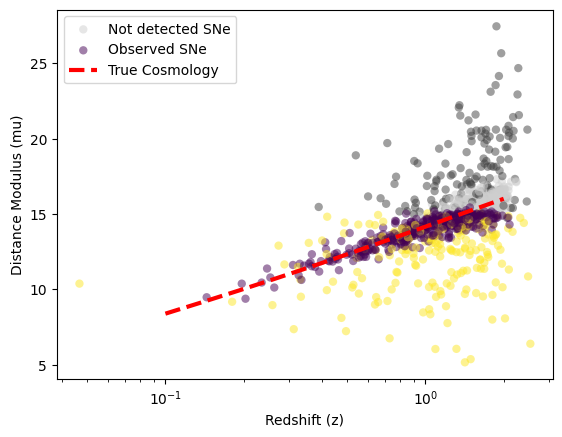

In [14]:
plt.scatter(obs_z[~detected], obs_mu[~detected], c=plt.get_cmap('Greys')(0.5*t[~detected]+0.3), alpha=0.5, label="Not detected SNe", linewidth =0)
plt.scatter(obs_z[detected], obs_mu[detected], c=t[detected], cmap='viridis', alpha=0.5, label="Observed SNe", linewidth =0)
z_line = jnp.linspace(0.1, 2, 1000)
plt.plot(z_line, 5*jnp.log10(jax.vmap(cosmology.luminosity_distance)(z_line))-5, 'r--', label='True Cosmology', linewidth = 3)
plt.xlabel('Redshift (z)')
plt.xscale("log")
plt.ylabel("Distance Modulus (mu)")
plt.legend()
plt.show()